Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.082118679373007].


nan
[0.06182039 0.08514189 0.20821187]


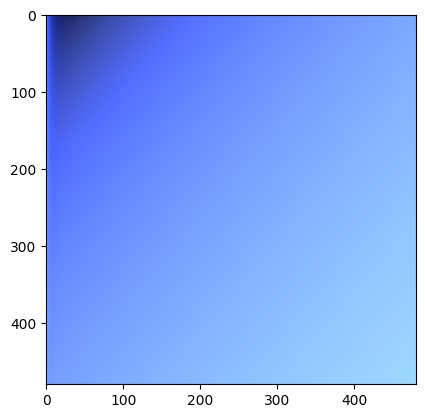

In [49]:
import grn
import numpy as np
import matplotlib.pyplot as plt


g = grn.GRN()
nin = 2
nout = 3

g.random(nin=nin, nout=nout, nreg=0)

N = 480


matrix = np.zeros((N,N,3))

for i in range(N):
    for j in range(N):
        g.set_input([i/N, j/N])
        g.step()   
        out = g.get_output()
        # if max(out) > 1:
        #     print("wtf")
        # print(out)
        matrix[i][j] = out


print(np.max(matrix[0][0]))
plt.imshow(matrix*10)

print(out)
# plt.savefig("test.png")

In [8]:
g.concentrations

array([4.79000000e+02, 4.79000000e+02, 0.00000000e+00, 5.84219899e+06,
       0.00000000e+00])

In [ ]:
str(g)
# Extract all values (including nested arrays)
all_values = []
for key, value in g.dict_grn.items():
    if isinstance(value, np.ndarray):  # Handle NumPy arrays
        all_values.extend(value.tolist())  # Convert array to list and extend
    else:  # Handle scalar values
        all_values.append(value)

# Result
tg = grn.GRN()
tg.from_genome(all_values)


[2, 3, 0, 0.4698914759149644, 0.5310835288365693, 1, 1, 1, 0.6182031503721237, 0.5079926787618018, 0.514002266883209, 0.5056875774927527, 0.3814980373850241, 0.0, 0.0, 0.6960123555450193, 0.7520445695442242, 0.29116703868547156, 0.9351495302374421, 0.416967886334073]
